<a href="https://colab.research.google.com/github/ASi-F/NLPlay-with-Transformers/blob/main/bert_large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Large

The BERT Transformer is available in 2 sizes- **base** and **large**. It has **12 encoders** stacked on top of each other and gives an output embedding of dimension 1024. Here we train the large model on a relatively small dataset by using a **Feed Forward Neural Network** with **3 hidden layers** and **1000 neurons per layer** architecture. The output embeddings are processed by this neural network which is trained on this dataset. <br> We have achieved an accuracy of 89.5% on the training set and 92.5% on the training set.<br> Not BAD! 

In [ ]:
pip install transformers

In [ ]:
pip install datasets

In [3]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import random 

# Prerocessing

The dataset is mounted from drive and some basic preprocessing is done to remove html tags. The review and sentiment columns are replaced by text and label columns. Here we convert the pandas df to dataset to pytorch dataloader

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')

In [5]:
def remove_tags(text):
    final = ""
    stt = True
    for char in text:
        if char == '<':
            stt = False
        if(stt):
            final = final + char
        if char == '>':
            stt = True
            final = final + ' '
    return final

df['text'] = df['review'].apply(remove_tags)

In [6]:
df = df.drop('review',axis = 1)

In [7]:
df['label'] = [ 1*(sent=='positive') for sent in df['sentiment']]

df = df.drop('sentiment', axis = 1)

In [8]:
df

,text,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming t...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [9]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

In [11]:
small_train_dataset = dataset.shuffle(seed=42).select(range(2000))
small_eval_dataset = dataset.shuffle(seed=42).select(range(2000,4000))

In [12]:
train_range = [i for i in range(0,50000) if 6>=i%10 and i%10>=0]
eval_range = [i for i in range(0,50000) if 9>=i%10 and i%10>=7]

train_dataset = dataset.select(train_range).shuffle(seed=42)
eval_dataset = dataset.select(eval_range) .shuffle(seed=42)

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=4)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=4)

# Model

In [14]:
from transformers import AutoModel
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [16]:
class Classifier(nn.Module):
  def __init__(self,hidden_dim,output_size):
    super(Classifier,self).__init__()

    self.model = AutoModel.from_pretrained("bert-large-uncased", num_labels=2)
  
    self.LF1 = nn.Linear(1024,hidden_dim)
    self.NLF1 = nn.ReLU()

    self.LF2 = nn.Linear(hidden_dim,hidden_dim)
    self.NLF2 = nn.ReLU()

    self.LF3 = nn.Linear(hidden_dim,output_size)

  def ready_train(self):
    (self.model).train()
  
  def ready_eval(self):
    self.model.eval()

  def forward(self,x):
    out = self.model(**x)[1]

    out = self.LF1(out)
    out = self.NLF1(out)

    out = self.LF2(out)
    out = self.NLF2(out)

    out = self.LF3(out)

    return F.softmax(out,dim=1)   

# Training

In [17]:
from tqdm.auto import tqdm

def train_classifier(num_epochs,train_dataloader,optimizer,classifier, loss_function = nn.CrossEntropyLoss()):
  losses = []
  num_training_steps = num_epochs*len(train_dataloader)
  progress_bar = tqdm(range(num_training_steps))
  classifier.ready_train()
  i = 0
  avg_loss = 0.
  for epoch in range(num_epochs):
    for batch in train_dataloader:
      # forward prop
      inp = tokenizer(batch['text'],padding=True, truncation=True,max_length=512, return_tensors="pt")
      inp = inp.to(device)
      out = classifier(inp)
      pred = batch['label']
      pred = pred.to(device)
      loss = loss_function(out, pred)

      # backward prop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())
      progress_bar.update(1)
      if i%100 == 0  and i//100>=1:
        print(avg_loss/100)
        avg_loss = 0
      i+=1
      avg_loss = avg_loss + float(loss.item())
  return losses

In [18]:
def plot_loss(losses):
  x = [i for i in range(0,len(losses))]
  plt.plot(x,losses)
  plt.title('Loss fnction')
  plt.ylabel('Loss')
  plt.xlabel('batch index')

def smooth_loss(losses,f):
  y = [0]*len(losses)
  for i in range(0,f):
    y[i] = (sum(losses[:i+1+f]))/(i+1+f)
  for i in range(f,len(losses)-f-1):
    y[i] = (sum(losses[i-f:i+f+1]))/(2*f+1)
  for i in range(len(losses)-f-1,len(losses)):
    y[i] = (sum(losses[i-f:]))/(len(losses)-i+f)
  plot_loss(y)

In [ ]:
output_size = 2
hidden_dim = 1000

classifier = Classifier(hidden_dim,output_size)
classifier.to(device)

# Evaluation

In [20]:
num_epochs = 3
lr = 1e-3
optimizer = optim.SGD(classifier.parameters(), lr)

tot_losses = train_classifier(num_epochs,train_dataloader,optimizer,classifier)

0.692954483628273
0.6932599687576294
0.6915153586864471
0.6893614083528519
0.6896078979969025
0.6796452575922012
0.6753974670171737
0.6601794052124024
0.6243306732177735
0.5797471109032631
0.5227460417151452
0.48789142578840256
0.4582219994068146
0.4520470082759857


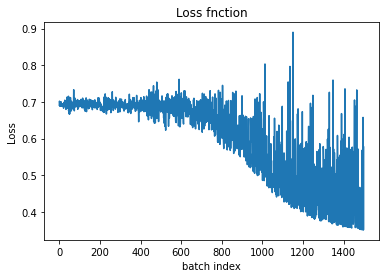

In [21]:
plot_loss(tot_losses)

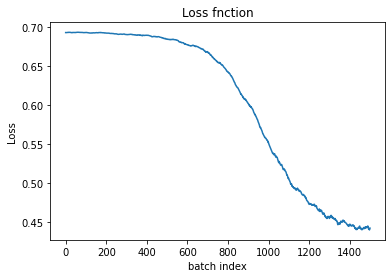

In [22]:
smooth_loss(tot_losses, 100)

In [23]:
classifier.ready_eval()
def acc(dataloader,classifier):
  corr = 0
  tot = len(dataloader)*4
  for batch in dataloader:
  # forward prop
    inp = tokenizer(batch['text'],padding=True, truncation=True,max_length=512, return_tensors="pt")
    inp = inp.to(device)
    out = list(torch.argmax(classifier(inp),dim=1))
    exp = list(batch['label'])
    
    for i,x in enumerate(out):
      if x == exp[i]:
        corr = corr+1
    
  return 100*(corr/tot)

In [24]:
acc(train_dataloader,classifier)

92.5

In [27]:
acc(eval_dataloader,classifier)

89.75

In [28]:
model_name = 'xlm-mlm-en-2048'

In [37]:
class ClassifierGen(nn.Module):
  def __init__(self,hidden_dim,output_size,model_name):
    super(ClassifierGen,self).__init__()

    self.model = AutoModel.from_pretrained(model_name, num_labels=2)
  
    self.LF1 = nn.Linear(2048,hidden_dim)
    self.NLF1 = nn.ReLU()

    self.LF2 = nn.Linear(hidden_dim,hidden_dim)
    self.NLF2 = nn.ReLU()

    self.LF3 = nn.Linear(hidden_dim,output_size)

  def ready_train(self):
    (self.model).train()
  
  def ready_eval(self):
    self.model.eval()

  def forward(self,x):
    out = self.model(**x)[1]

    out = self.LF1(out)
    out = self.NLF1(out)

    out = self.LF2(out)
    out = self.NLF2(out)

    out = self.LF3(out)

    return F.softmax(out,dim=1)   

In [30]:
tokenizer = AutoTokenizer.from_pretrained(model_name)